# Import all libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16

# Declare Variables

In [2]:
imagesize=224
batchsize=32
channel=3

# Import dataset of images from Folder

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "image_dataset",
    shuffle=True,
    image_size=(imagesize,imagesize),
    batch_size=batchsize
) #load dataset

Found 12120 files belonging to 2 classes.


# Find number of classes (no. of sub folder )

In [4]:
class_names=dataset.class_names
class_names

['fake', 'real']

In [5]:
len(dataset)

379

In [6]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch) #tf object
    print(label_batch.numpy) #tf object to numpy

(32, 224, 224, 3)
tf.Tensor([0 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 0 1 0 1 0 0 1 1 0 1 1 1 0 1 1 1], shape=(32,), dtype=int32)
<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1])>>


# Display image of dataset

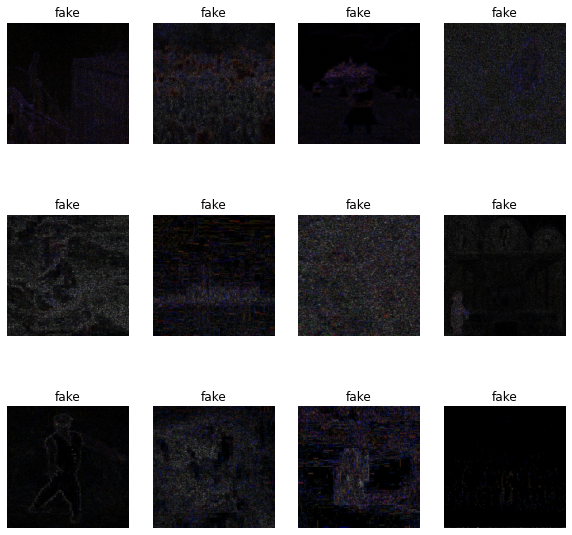

In [7]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    #print(image_batch[i])# image 1
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))# image in int
        plt.axis("off")
        plt.title(class_names[label_batch[0].numpy()])

#  Divide Dataset into train and test

In [8]:
train_size=0.8 #size of training 80%

train_dataset=dataset.take(int(len(dataset)*train_size)) #a[:60]
test_dataset=dataset.skip(int(len(dataset)*train_size)) #a[60:]
train_dataset=train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset=test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
resize_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(imagesize,imagesize),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

#  VGG16 Model Loading

In [10]:
input_shape=(imagesize,imagesize,channel)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers to the model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

In [11]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 21,137,986
Trainable params: 6,423,298
Non-trainable params: 14,714,688
_________________________________________________________________


In [12]:
model.compile(
    optimizer="Adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
) 
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training Dataset

In [13]:
history=model.fit(
    train_dataset,
    epochs=10,
    batch_size=batchsize,
    verbose=1,
)

Epoch 1/10
303/303 [==============================] - 1255s 4s/step - loss: 0.9553 - accuracy: 0.8022
Epoch 2/10
303/303 [==============================] - 1220s 4s/step - loss: 0.3374 - accuracy: 0.8523
Epoch 3/10
303/303 [==============================] - 1212s 4s/step - loss: 0.2921 - accuracy: 0.8702
Epoch 4/10
303/303 [==============================] - 1208s 4s/step - loss: 0.2584 - accuracy: 0.8878
Epoch 5/10
303/303 [==============================] - 1309s 4s/step - loss: 0.2562 - accuracy: 0.8831
Epoch 6/10
303/303 [==============================] - 2584s 9s/step - loss: 0.2191 - accuracy: 0.9044
Epoch 7/10
303/303 [==============================] - 2660s 9s/step - loss: 0.2002 - accuracy: 0.9081
Epoch 8/10
303/303 [==============================] - 2321s 8s/step - loss: 0.1919 - accuracy: 0.9135
Epoch 9/10
303/303 [==============================] - 1407s 5s/step - loss: 0.1694 - accuracy: 0.9211
Epoch 10/10
303/303 [==============================] - 1273s 4s/step - loss: 0.169

# Test data (evaluating)

In [14]:
 score=model.evaluate(test_dataset)

76/76 [==============================] - 318s 4s/step - loss: 0.3160 - accuracy: 0.8787


# Training Progress

Text(0.5, 1.0, 'EPOCHS vs accuaracy')

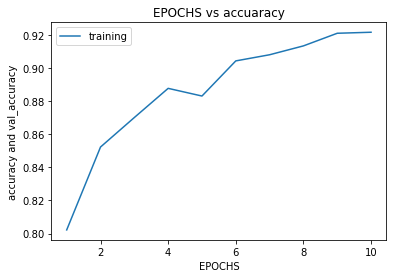

In [15]:
plt.subplot(1,1,1)
plt.plot(range(1,11),history.history['accuracy'])
plt.legend(("training"," validation"))
plt.ylabel("accuracy and val_accuracy")
plt.xlabel("EPOCHS")
plt.title("EPOCHS vs accuaracy")

# Testing predicted result vs actual result

1/1 [==============================] - 4s 4s/step
actual: real
predict: real


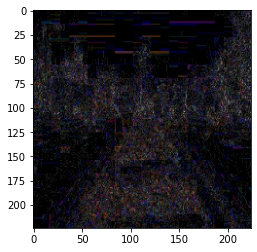

In [16]:
import numpy as np
for image_batch,label_batch in test_dataset.take(1):
    first_image=image_batch[0].numpy().astype("uint8")
    first_batch=label_batch[0].numpy()
    plt.imshow(first_image)
    batch_pred=model.predict(image_batch)
    print("actual:",class_names[first_batch])
    print("predict:",class_names[np.argmax(batch_pred[0])]) 

In [17]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    
    predictions=model.predict(img_array)
    print(predictions)
    pred_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return pred_class,confidence

1/1 [==============================] - 0s 371ms/step
[[1.02036736e-07 9.99999881e-01]]
1/1 [==============================] - 0s 161ms/step
[[6.4659381e-04 9.9935335e-01]]
1/1 [==============================] - 0s 151ms/step
[[2.8309110e-05 9.9997175e-01]]
1/1 [==============================] - 0s 207ms/step
[[0.26108757 0.7389124 ]]
1/1 [==============================] - 0s 189ms/step
[[0.25635973 0.74364024]]
1/1 [==============================] - 0s 220ms/step
[[0.90022403 0.09977599]]
1/1 [==============================] - 0s 184ms/step
[[0.00333287 0.9966671 ]]
1/1 [==============================] - 0s 184ms/step
[[0.86821055 0.1317894 ]]
1/1 [==============================] - 0s 146ms/step
[[0.41207844 0.58792156]]
1/1 [==============================] - 0s 155ms/step
[[0.00174575 0.99825424]]
1/1 [==============================] - 0s 154ms/step
[[0.00225286 0.9977471 ]]
1/1 [==============================] - 0s 173ms/step
[[0.00273561 0.9972644 ]]


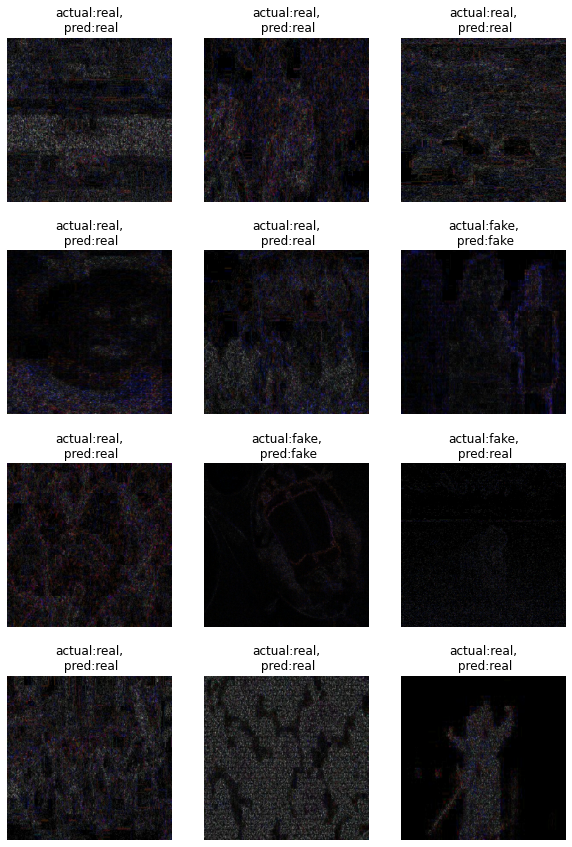

In [18]:
plt.figure(figsize=(10,15))
for images,labels in test_dataset.take(1):
    for i in range(12):
        ax=plt.subplot(4,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        pred_class,confidence=predict(model,images[i].numpy())
        act_class=class_names[labels[i]]
        plt.title(f"actual:{act_class},\n pred:{pred_class}")
        plt.axis("off")

# Model Save

In [19]:
model_version="image_detection"
model.save(f"model/{model_version}")

INFO:tensorflow:Assets written to: model/image_detection\assets


INFO:tensorflow:Assets written to: model/image_detection\assets
